# Project Overview
Years ago I made a project that classified spam and non spam texts. The notebook was very slopy and did not make a lot of sense. It is a fairly easy task but did not get its right explanation and attention in the previous notebook so I will be re doing it. In this updated version of the notebook I will explore the data. For this notebook I've choose to use naive bayes as the model. Before the model creation I will also go over the math behind naive bayes. Lastly I will evaluate the results and give my conclusion

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Above we have imported some librarires. The data is in file called `data`. This is pretty straight forward we just load it in using pandas. Once we load it in we will exploring the data.

In [3]:
data = pd.read_csv("./data", sep="\t", names=["label", "message",]) # load in data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


From this we know that we have a total of 5572 samples. We have no null values and they are both object types. Before we get into data exploration it would be helpful to first make the labels `int` type. Lets first see what our data looks like.

In [5]:
data.head()

,label,message
0,spam,URGENT! This is the 2nd attempt to contact U!U...
1,ham,:( but your not here....
2,ham,Not directly behind... Abt 4 rows behind ü...
3,spam,Congratulations ur awarded 500 of CD vouchers ...
4,spam,Had your contract mobile 11 Mnths? Latest Moto...


To start with we first need to turn our labels into numerical values. `Spam` will be represented by `1` and `Ham` (no spam) will be represented by `0`.

In [6]:
# converting text label into numerical values such as ham=0, spam=1
label_mapping = {'ham': 0, 'spam': 1}
data['label'] = data['label'].map(label_mapping)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [8]:
data['label'].value_counts() # count how much of spam and non spam messages we have

label
0    4825
1     747
Name: count, dtype: int64

We have a small ammount of `spam` messages compared to `ham` messages. We have a total of `4825` `ham` messages and `747 spam` messages. This is very unbalanced so we will see what the results are. It is good to have equal ammount of examples from each class when doing classification. `747` `spam` messages is still a good amount for us to train on. We have a lot of `spam` examples which is good. This means that our model will have a lot of examples to learn to detect spam correctly. LEts continue exlporing our data!

In [9]:
data['message'] = data['message'].str.lower() # convert messages lowercase

In [10]:
data.head(10)

,label,message
0,1,urgent! this is the 2nd attempt to contact u!u...
1,0,:( but your not here....
2,0,not directly behind... abt 4 rows behind ü...
3,1,congratulations ur awarded 500 of cd vouchers ...
4,1,had your contract mobile 11 mnths? latest moto...
5,1,urgent! call 09066350750 from your landline. y...
6,0,no plans yet. what are you doing ?
7,0,hi ....my engagement has been fixd on &lt;#&g...
8,0,not course. only maths one day one chapter wit...
9,0,wow didn't think it was that common. i take it...


It would be helpful to see which words appear in spam messages the most. This would help us see if certains words contribute more to a message being `spam`. What we will do first is remove stop words Stop words are words like `the`, `to` and `a`. The reason for this is because it is highly likely that these words appear in both `spam`and `ham` messages and would have little to know affect on detecting `spam`.

In [11]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

I had to download stop words from [here](https://gist.github.com/sebleier/554280). Then I put the list in my `env` folder. 

In [12]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    words = text.split() 
    filtered_words = [word for word in words if word.lower() not in stop_words]  
    return ' '.join(filtered_words)

In [13]:
data['message'] = data['message'].apply(remove_stopwords)

Now we want to create two dataframes one for `spam` messages and the other for `ham` messaages. 

In [ ]:
spam = data[data['label'] == 1] # seperate the data
ham = data[data['label'] == 0]

Then we create a list of all the words in our message. One list for `spam` and one for `ham`.

In [ ]:
spam_words = ' '.join(spam['message']).lower().split() # crate a list of spam and ham words
ham_words = ' '.join(ham['message']).lower().split()

In the cell below we count the occurence of our words. After that we will create two dataframes (one for `spam` and one for `ham`). Both will have columns `word` and `count`. 

In [16]:
spam_word_counts = Counter(spam_words) # count the words
ham_word_counts = Counter(ham_words)

In [17]:
# make a dataframe with the word and its count
spam_word_count_df = pd.DataFrame(spam_word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
ham_word_count_df = pd.DataFrame(ham_word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

In [18]:
spam_word_count_df.head()

,word,count
47,call,342
20,free,180
22,2,169
12,ur,144
26,txt,136


Here we can see that `call` appears `432` times in the spam messages. Free appears `180` times in spam messages.  

In [19]:
ham_word_count_df.head(5)

,word,count
44,u,881
150,get,293
149,2,288
16,&lt;#&gt;,276
41,ur,241


In non spam messages the most common word or symbol is `u` which appears `861` times. Then `get` appears 293 times. However a word like `ur` appears frequently in both `spam` and `ham`. For example in `spam` messages `ur` appears `144` times. While in `ham` messages `ur` appears `241` times. The count is very valuable and will be used in our modeling in naivey bayes. If we only knew the words that appeared the most in each message and not the count we could run into issues whem modeling. Moving on lets graph the 10 most frequent words in both dataframes.

Text(0, 0.5, 'count')

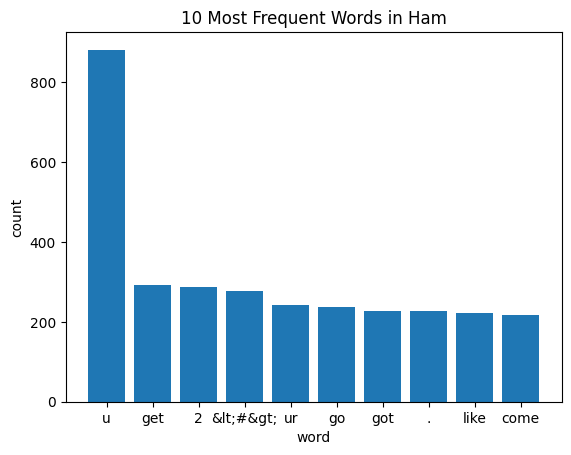

In [25]:
plt.bar(ham_word_count_df.head(10)['word'], ham_word_count_df.head(10)['count'])
plt.title('10 Most Frequent Words in Ham')
plt.xlabel('word')
plt.ylabel('count')

The 10 most frequent words in our `ham` messages are `u, get, 2, &lt;#&gt;, ur, go, got, ., like` and `come`. This makes sense as they seem like pretty standard words. Words like `go`, `get`, or `come` could be invations or making plans. Although they are invitational words like youd see in `spam` messages they appear frequently in `ham` which makes a difference. I'm not sure what `&lt;#&gt;` is but ideally we would remove it, same with `.`.  Lets move onto the `spam` words

Text(0, 0.5, 'count')

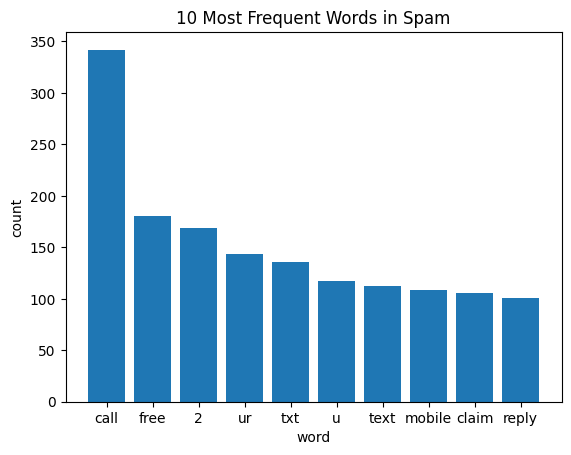

In [26]:
plt.bar(spam_word_count_df.head(10)['word'], spam_word_count_df.head(10)['count'])
plt.title('10 Most Frequent Words in Spam')
plt.xlabel('word')
plt.ylabel('count')

The 10 most frequent words in our `ham` messages are `call, free, 2, ur, txt, u, text, mobile, claim` and `reply`. A lot of these words imply that you have won something. For example `free, claim, reply` seem like someone is alerting you that you won something and must reply to clain it. These words make sense for being here. It is interesting to see that `call` appears so many more times compared to other words.

Now that we have learned about our data its time to begin learning about naive bayes and the math behind it. Naive Bayes uses probability theory specifically Bayes Theorem. Here are some further readings on [Bayes Theorem]() and [Naive Bayes](). First lets go over some proability basics.

- $X$ denotes a random variable
- $ P(X=x)$ denotes the probability of a random varible $X$ taking on a value $x$
- $P(X=x|Y=y)$ denotes the probability of a random variable $X$ taking on a value $x$ given the the random variable $Y$ has taken on some value $y$.  This is also known as **conditional probability**.
- $P(X=x \cap Y=y)$ the **intersection** of X and Y. This is the probability that X and Y happen.
- $P(X=x|Y=y) = \frac{P(X=x \cap Y=y)}{P(Y=y)}$ This is how we calculate condtional probability
- **Bayes Theorem** $ P(X=x|Y=y) = \frac{P(Y=y|X=x)P(X=x)}{P(Y=y)}$
- This is how we derive bayes theorem
  $$P(X \cap Y) = P(Y \cap X)$$
  $$P(X=x | Y=y) = \frac{P(X=x \cap Y=y)}{P(Y=y)} = \frac{P(Y=y \cap X=x)}{P(Y=y)}$$
  Conditional probability says $$P(Y=y|X=x)=\frac{P(Y=y\cap X=x)}{P(X=x)} $$
  $$P(Y=y \cap X=x) = P(Y=y|X=x) P(X=x)$$
  $$ P(X=x|Y=y) = \frac{P(Y=y|X=x)P(X=x)}{P(Y=y)}$$

Weve gone over some probability basiscs and how we derive bayes theorem. Now lets see how we can use this to help us detect spam messages.

Our goal is to classify detect spam given some message. Rephrasing that into probability theory we want to know what the probability of a message being spam given the words to the message. In math we have: 
$$P(\text{message is spam}|\text{words in message})$$
Let's define some random variables.
Let $X$ denote the event that a message is spam. Let $Y_{1 \dots n}=y_{1 \dots n}$ denote that our message contains some word. For example $Y_1=y_1$ could denote that the message contains the word `free`, $Y_2=y_2$ could denote `claim` etc. The math for that would then be:
$$P(X=spam|Y_{1 \dots n}=y_{1 \dots n}) = \frac{P(Y_{1 \dots n}=y_{1 \dots n}|X=spam)P(X=spam)}{P(Y_{1 \dots n}=y_{1 \dots n})}$$
The equation above says that 

## Model Building
As mentioned above I am going to use naive bayes. Below will be some grid search along with the model building and evaluation. First we need to split our data tho. I am not going to be explaining the math of how naive bayes works but it uses probability theory and you can read more about it [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) 

In [21]:
X = data['message']
y = data['label']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that we have split our data we want to extract useful features from the messages. These features will help our model learn what a spam and not spam message looks like.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [26]:
tfidf = TfidfVectorizer(stop_words='english')

In [27]:
X_train_tfidf = tfidf.fit_transform(X_train) # transform our message data

In [30]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
X_test_tfidf = tfidf.transform(X_test)

In [33]:
y_pred = model.predict(X_test_tfidf)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       963
           1       1.00      0.80      0.89       152

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [36]:
new_message = ["are u free tonight?"]
new_message_tfidf = tfidf.transform(new_message)
prediction = model.predict(new_message_tfidf)

In [37]:
prediction

array([0])